In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten, Average 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imutils

In [2]:
train_root  = "dataset2-master/images/TRAIN"
test_root = "dataset2-master/images/TEST"

In [3]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (72,96)

In [4]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

def load_data(root):

    datasets = [root]
    images = []
    labels = []

    # iterate through training and test sets
    count =0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open 
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # add padding to the image to better detect cell at the edge
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                #thresholding the image to get the target cell
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                # openning errosion then dilation
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                #detecting the blood cell
                edgedImage = findEdges(image1)
                edgedContours = getImgContours(edgedImage)
                edgedBoxes =  getBoxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                # any pixel but the pixels inside the contour is zero
                image[mask==0] = 0
                
                # extract th blood cell
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                # resize th image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    n = 0
    for i in range(4):
        for j in range(5):
            plt.subplot(4,5,i*5+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            while labels[n]!=i:
                n = n + 1
            plt.imshow(images[n], cmap=plt.cm.binary)
            plt.xlabel(class_names[labels[n]])
            n = n + 1

In [5]:
images, labels = load_data(train_root)

100%|█████████████████████████████████████████████████████████████████████████████| 2499/2499 [00:08<00:00, 280.57it/s]


In [6]:
test_images, test_labels = load_data(test_root)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:02<00:00, 293.86it/s]


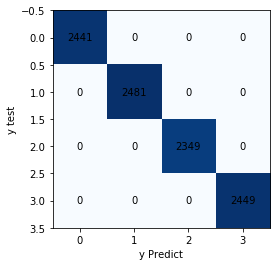

In [7]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(labels, labels)
# Plot confusion matrix
plt.imshow(cm2,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm2):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y test")
plt.grid(False)
plt.show()

In [8]:
images, labels = shuffle(images, labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [9]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.25)

In [10]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

In [11]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(7290, 96, 72, 3)
(7290,)
(2430, 96, 72, 3)
(2430,)


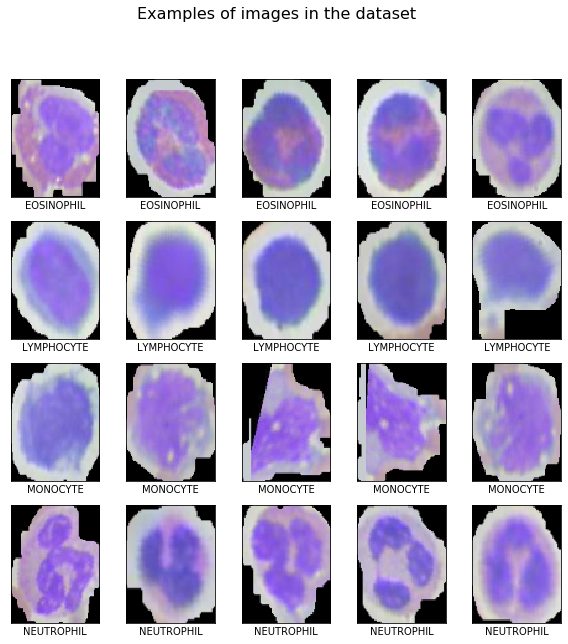

In [12]:
display_examples(class_names, train_images, train_labels)

In [13]:
# Using Resnet
import keras
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras.models import Model
from sklearn.ensemble import VotingClassifier

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(96,72,3))

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model_base = Sequential()
model_base.add(restnet)
model_base.add(Flatten())
model_base.add(Dense(512, activation='relu'))
model_base.add(Dropout(0.3))
model_base.add(Dense(64, activation='relu'))
model_base.add(Dropout(0.3))
model_base.add(Dense(4, activation='softmax'))

#voting=VotingClassifier(estimators=[('a',model2),('b',model2),('c',model2),('d',model2)],voting='soft')

In [14]:
input_shape=(96,72,3) 
model_input = Input(shape=input_shape)

In [15]:
def resnet50(model_input):
    
    x = Sequential()(model_input)
    x = ResNet50(include_top=False, weights='imagenet', input_shape=(96,72,3))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(4, activation='softmax')(x)
    
    model = Model(model_input, x, name='resnet50')
    
    return model

In [16]:
def resnet101(model_input):
    
    x = Sequential()(model_input)
    x = ResNet101(include_top=False, weights='imagenet', input_shape=(96,72,3))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(4, activation='softmax')(x)
    
    model = Model(model_input, x, name='resnet101')
    
    return model

In [17]:
def resnet152(model_input):
    
    x = Sequential()(model_input)
    x = ResNet152(include_top=False, weights='imagenet', input_shape=(96,72,3))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(4, activation='softmax')(x)
    
    model = Model(model_input, x, name='resnet152')
    
    return model

In [18]:
def cnn(model_input):
    
    x = Sequential()(model_input)
    x = Conv2D(32, (3, 3), input_shape=(96,72,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = Dropout(0.05)(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = Dropout(0.05)(x)
    x = Conv2D(48, (3, 3),activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(48, (4, 4), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation="softmax")(x)
    
    
    model = Model(model_input, x, name='cnn')
    
    return model

In [19]:
resnet50 = resnet50(model_input)
resnet101 = resnet101(model_input)
cnn = cnn(model_input)
models = [resnet50, resnet101, cnn]
history = []

In [20]:
def compile_and_train(model, epochs = 20): 
    
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 
    # filepath = './weights/' + model.name + '.hdf5'
    # checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_weights_only=True, save_best_only=True, mode='auto', period=1)
    # tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=32)
    history = model.fit(train_images, train_labels, batch_size = 32, epochs = epochs, validation_data=(val_images, val_labels))
    
    return history

In [29]:
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

for i in range(len(models)):
    history.append(compile_and_train(models[i],epochs=25))

Epoch 1/25
228/228 [==============================] - 408s 2s/step - loss: 0.4617 - accuracy: 0.8503 - val_loss: 0.6956 - val_accuracy: 0.7770
Epoch 2/25
228/228 [==============================] - 402s 2s/step - loss: 0.3796 - accuracy: 0.8923 - val_loss: 0.6906 - val_accuracy: 0.7255
Epoch 3/25
228/228 [==============================] - 386s 2s/step - loss: 0.2304 - accuracy: 0.9055 - val_loss: 0.1653 - val_accuracy: 0.9387
Epoch 4/25
228/228 [==============================] - 350s 2s/step - loss: 0.2271 - accuracy: 0.9316 - val_loss: 2.1554 - val_accuracy: 0.4000
Epoch 5/25
228/228 [==============================] - 347s 2s/step - loss: 0.2418 - accuracy: 0.9198 - val_loss: 0.4707 - val_accuracy: 0.8407
Epoch 6/25
228/228 [==============================] - 343s 2s/step - loss: 0.2285 - accuracy: 0.9364 - val_loss: 5.4996 - val_accuracy: 0.3901
Epoch 7/25
228/228 [==============================] - 345s 2s/step - loss: 0.3007 - accuracy: 0.9027 - val_loss: 0.3675 - val_accuracy: 0.8835

228/228 [==============================] - 21s 91ms/step - loss: 0.0687 - accuracy: 0.9764 - val_loss: 0.1066 - val_accuracy: 0.9626
Epoch 9/25
228/228 [==============================] - 21s 91ms/step - loss: 0.1002 - accuracy: 0.9641 - val_loss: 0.1092 - val_accuracy: 0.9663
Epoch 10/25
228/228 [==============================] - 21s 90ms/step - loss: 0.0643 - accuracy: 0.9778 - val_loss: 0.0859 - val_accuracy: 0.9683
Epoch 11/25
228/228 [==============================] - 21s 91ms/step - loss: 0.0795 - accuracy: 0.9728 - val_loss: 0.0935 - val_accuracy: 0.9683
Epoch 12/25
228/228 [==============================] - 21s 91ms/step - loss: 0.0642 - accuracy: 0.9771 - val_loss: 0.1010 - val_accuracy: 0.9691
Epoch 13/25
228/228 [==============================] - 21s 91ms/step - loss: 0.0909 - accuracy: 0.9684 - val_loss: 0.1030 - val_accuracy: 0.9650
Epoch 14/25
228/228 [==============================] - 21s 91ms/step - loss: 0.0660 - accuracy: 0.9783 - val_loss: 0.0932 - val_accuracy: 0.970

In [30]:
def evaluate(model):
    #  score = model.evaluate(test_images,test_labels)
    pred = model.predict(test_images, batch_size = 32)
    pred = np.argmax(pred, axis=1)
    # pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    score = 1 - np.sum(np.not_equal(pred, test_labels)) / test_labels.shape[0]  
    return score

In [31]:
for i in range(len(models)):
    print(evaluate(models[i]))

76/76 [==============================] - 20s 253ms/step
0.8293487221764221
76/76 [==============================] - 31s 381ms/step
0.3318219291014015
76/76 [==============================] - 1s 17ms/step
0.8499587798845837


In [32]:
from sklearn.metrics import confusion_matrix

def plot_accuracy_loss(model, history, root):
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(root + '/accuracy_' + model.name + '.jpg', dpi=200, bbox_inches='tight')
    plt.show()
    
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(root + '/loss_' + model.name + '.jpg', dpi=200, bbox_inches='tight')
    plt.show()

def plot_confusion_matrics(model, root, test_images, test_labels):
    pred1 = np.argmax(model.predict(test_images),axis=1)
    cm2 = confusion_matrix(test_labels, pred1)
    # Plot confusion matrix
    plt.imshow(cm2,interpolation='none',cmap='Blues')
    for (i, j), z in np.ndenumerate(cm2):
        plt.text(j, i, z, ha='center', va='center')
    plt.xlabel("y Predict")
    plt.ylabel("y test")
    plt.grid(False)
    plt.savefig(root + '/confusion_matrix_' + model.name + '.jpg', dpi=200, bbox_inches='tight')
    plt.show()

------------------------------------------------------
------------------第1个模型------------------
------------------------------------------------------


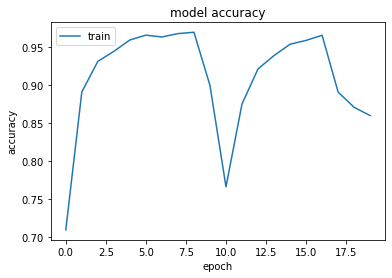

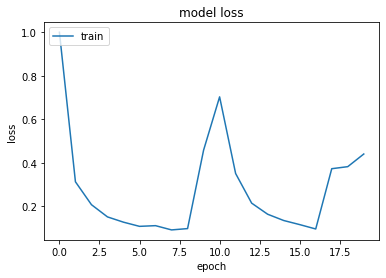

76/76 [==============================] - 17s 227ms/step


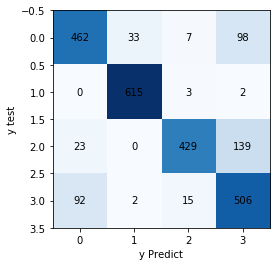

------------------------------------------------------
------------------第2个模型------------------
------------------------------------------------------


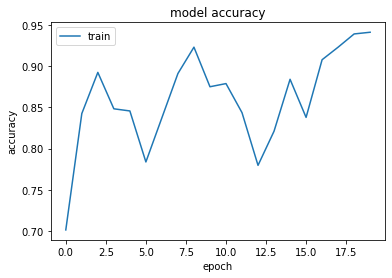

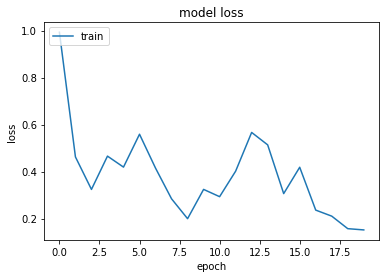

76/76 [==============================] - 29s 382ms/step


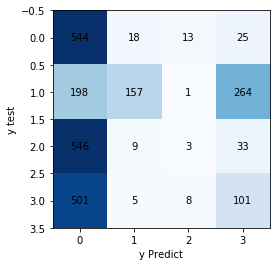

------------------------------------------------------
------------------第3个模型------------------
------------------------------------------------------


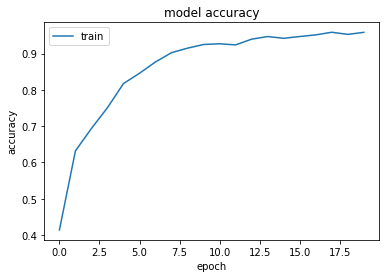

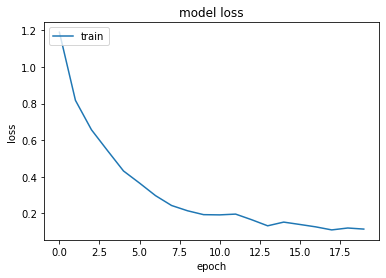

76/76 [==============================] - 1s 17ms/step


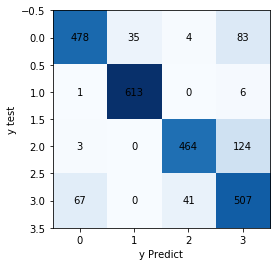

In [33]:
for i in range(len(models)):
    print('------------------'*3)
    print('------------------第{}个模型------------------'.format(i+1))
    print('------------------'*3)
    plot_accuracy_loss(models[i], history[i], './picture/bagging_learning_really')
    plot_confusion_matrics(models[i], './picture/bagging_learning_really', test_images, test_labels)
# plot_accuracy_loss(resnet50, history2, './picture/bagging_learning_really')
# plot_confusion_matrics(resnet50, './picture/bagging_learning_really', test_images, test_labels)

In [34]:
def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

In [35]:
ensemble_model = ensemble(models, model_input)

76/76 [==============================] - 45s 555ms/step
0.8392415498763397
76/76 [==============================] - 42s 549ms/step


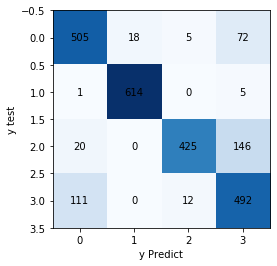

In [36]:
print( evaluate(ensemble_model))
plot_confusion_matrics(ensemble_model, './picture/bagging_learning_really', test_images, test_labels)